In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_path='./drive/My Drive/'

In [0]:
import pickle
from sklearn.model_selection import train_test_split
from scipy import misc
from skimage.transform import resize
from skimage.io import imread
from keras.layers.core import Lambda, RepeatVector, Reshape
import numpy as np
import os
image_dir="./drive/My Drive/Dataset2"
label = os.listdir(image_dir)
label = label[1:]
dataset = []

for image_label in label:
    images = os.listdir("./drive/My Drive/Dataset2/"+image_label)
   
    for image in images:
        img = imread("./drive/My Drive/Dataset2/"+image_label+"/"+image)
        img = resize(img, (224, 224))
        dataset.append((img,image_label))
X = []
Y = []

for input,image_label in dataset:
   X.append(input)
   Y.append(label.index(image_label))

X = np.array(X)
Y = np.array(Y)


X_full = X
y_full = Y
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size = 0.3)






#X_train,y_train, X_test,y_test, = X,Y

#data_set = (X_train,y_train)

# save_label = open("int_to_word_out.pickle","wb")
# pickle.dump(label, save_label)
# save_label.close()

Using TensorFlow backend.


In [0]:
print(x_train.shape[1:])

(224, 224, 3)


In [0]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [32, 39, 28, 30, 30, 35, 34, 36, 35, 37, 33, 33, 37, 33, 28, 38, 34, 36, 35, 36, 38, 35, 34, 34, 38, 37, 37, 30, 32]
test groups: [18, 11, 12, 10, 20, 15, 17, 14, 14, 14, 18, 17, 13, 17, 12, 12, 16, 14, 15, 14, 12, 15, 16, 16, 12, 13, 11, 20, 18]


In [0]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx] 
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
            
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
            
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

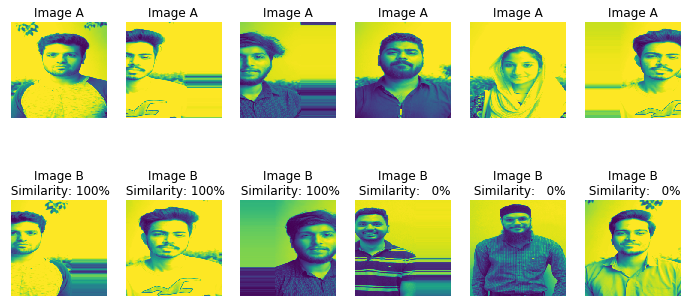

In [0]:
import matplotlib.pyplot as plt
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [0]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout
img_in = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPool2D((2,2))(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer], name = 'FeatureGenerationModel')
feature_model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 8)       224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 8)       32        
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 220, 220, 16)

In [0]:
#Contrastive Loss
def euclid_dist(input_pair):
    x, y = input_pair
    distance = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return distance

def euclid_dist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = -1 * y_true + 1
    return K.mean((1-y_true) * K.square(y_pred) + y_true *  K.square(K.maximum(margin - y_pred, 0.0)))

def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)

In [0]:
INIT_WEIGHTS = os.path.join(root_path, 'init_weights_shahzaib_model.hdf5')
CHECKPOINTED_WEIGHTS = os.path.join(root_path, 'checkpointed_weights_shahzaib_model.hdf5')

In [0]:
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import time
import pickle

In [0]:
from keras.layers import concatenate
img_a_in = Input(shape = x_train.shape[1:], name = 'image_1')
img_b_in = Input(shape = x_train.shape[1:], name = 'image_2')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat])
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
# distance = Lambda(euclid_dist, output_shape=euclid_dist_shape)([img_a_feat, img_b_feat])
# prediction = Dense(1, activation='sigmoid')(distance)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs = combined_features, name = 'Similarity_Model')
# optimizer = Adam(lr = 0.00006)
similarity_model.compile(loss=contrastive_loss, optimizer='adam', metrics=[acc])
similarity_model.summary()
os.system("rm {}".format(INIT_WEIGHTS))
similarity_model.save_weights(INIT_WEIGHTS)



Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Model)  (None, 32)           2885216     image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 64)           0           FeatureGeneration

In [0]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['mae'])

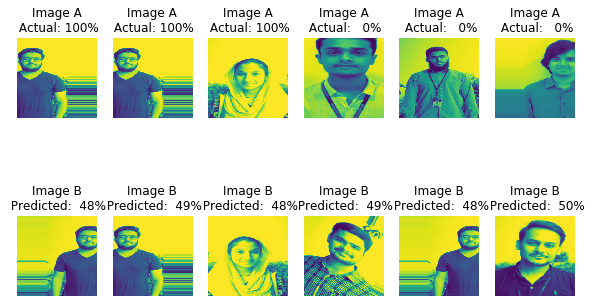

In [0]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (10, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

In [0]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 100)
loss_history = similarity_model.fit_generator(siam_gen(train_groups), 
                               steps_per_epoch = 10,
                               validation_data=([valid_a, valid_b], valid_sim),
                                              epochs = 100,
                                                 verbose = True)

Epoch 1/100
10/10 [==============================] - 39s 4s/step - loss: 0.1519 - acc: 0.8031 - val_loss: 0.1851 - val_acc: 0.7100
Epoch 2/100
10/10 [==============================] - 39s 4s/step - loss: 0.1475 - acc: 0.7750 - val_loss: 0.1844 - val_acc: 0.7100
Epoch 3/100
10/10 [==============================] - 39s 4s/step - loss: 0.1566 - acc: 0.7781 - val_loss: 0.1896 - val_acc: 0.7050
Epoch 4/100
10/10 [==============================] - 39s 4s/step - loss: 0.1749 - acc: 0.7469 - val_loss: 0.1796 - val_acc: 0.7200
Epoch 5/100
10/10 [==============================] - 39s 4s/step - loss: 0.1622 - acc: 0.7750 - val_loss: 0.1725 - val_acc: 0.7450
Epoch 6/100
10/10 [==============================] - 39s 4s/step - loss: 0.1516 - acc: 0.7906 - val_loss: 0.1809 - val_acc: 0.7100
Epoch 7/100
10/10 [==============================] - 39s 4s/step - loss: 0.1379 - acc: 0.8156 - val_loss: 0.1936 - val_acc: 0.7100
Epoch 8/100
10/10 [==============================] - 39s 4s/step - loss: 0.1562 - a

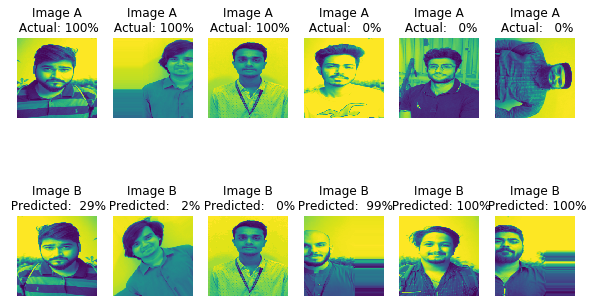

In [0]:
_ = show_model_output()

In [0]:
affan_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
affan_score = similarity_model.predict([affan_vec, x_test], verbose = True, batch_size = 128)
ahmed_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ahmed_score = similarity_model.predict([ahmed_vec, x_test], verbose = True, batch_size = 128)

426/426 [==============================] - 15s 36ms/step


In [0]:
x_test_features = feature_model.predict(x_test, verbose = True, batch_size=128)

426/426 [==============================] - 8s 19ms/step


In [0]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 426 samples in 0.001s...
[t-SNE] Computed neighbors for 426 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 426 / 426
[t-SNE] Mean sigma: 0.974007
[t-SNE] Computed conditional probabilities in 0.032s
[t-SNE] Iteration 50: error = 53.3054466, gradient norm = 0.4821064 (50 iterations in 0.150s)
[t-SNE] Iteration 100: error = 52.9179497, gradient norm = 0.5039508 (50 iterations in 0.115s)
[t-SNE] Iteration 150: error = 53.0758018, gradient norm = 0.4870313 (50 iterations in 0.119s)
[t-SNE] Iteration 200: error = 53.5615578, gradient norm = 0.4755890 (50 iterations in 0.118s)
[t-SNE] Iteration 250: error = 52.8527489, gradient norm = 0.5054642 (50 iterations in 0.120s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.852749
[t-SNE] Iteration 300: error = 0.2796371, gradient norm = 0.0014545 (50 iterations in 0.111s)
[t-SNE] Iteration 350: error = 0.2062341, gradient norm = 0.0005151 (